# Develop Fixed-radius NN Linear-time Algorithm

Explore the techniques described in [this paper](https://reader.elsevier.com/reader/sd/pii/0020019077900709?token=E45C0E1870EA26C21C1F149B6090CE4630A51269D324BE1206B7BF2764FB48B2DDC93F4B86FBFBD8CBDED63B15BBC6DA&originRegion=us-east-1&originCreation=20210428165528).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
from sklearn import metrics, decomposition
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

import faiss

sys.path.append('/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/TrackML_Example')
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare example data

In [6]:
d = 2                           # dimension
nb = 10000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).type(dtype)

## Explore Bentley algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grispy import GriSPy

In [81]:
# Create random points and centres
Npoints = 10 ** 3
Ncentres = 2
dim = 2
Lbox = 100.0

In [82]:
np.random.seed(2)
data = np.random.uniform(0, Lbox, size=(Npoints, dim))
centres = np.random.uniform(0, Lbox, size=(Ncentres, dim))

In [83]:
# Grispy params
upper_radii = 15.0
lower_radii = 10.0
n_nearest = 100

In [84]:
%%time
gsp = GriSPy(data)

CPU times: user 6.48 ms, sys: 0 ns, total: 6.48 ms
Wall time: 5.91 ms


In [85]:
%%time
bubble_dist, bubble_ind = gsp.bubble_neighbors(
    data, distance_upper_bound=upper_radii
)

CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 579 ms


In [80]:
# Plot results
plt.figure(1, figsize=(10, 10))

plt.subplot(1, 1, 1, aspect="equal")
plt.title("Bubble query")
plt.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=3)
for ind in bubble_ind:
    plt.scatter(data[ind, 0], data[ind, 1], c="C3", marker="o", s=5)
plt.plot(centres[:, 0], centres[:, 1], "ro", ms=10)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2aaad73e7560> (for post_execute):


KeyboardInterrupt: 

In [58]:
bubble_ind

[array([9046, 6441, 2552, 4488, 6392, 3276, 6926, 2311, 2141, 4422, 6045,
        6775, 9279, 5958, 3956, 5619, 5543, 3178, 6859, 6189, 2840, 5347,
         919,   51, 7777, 8670, 2198, 7663, 1140, 1889, 6402, 8889,  624,
        3163, 1622, 6705, 5040, 1218, 4986, 8974, 2903, 9920, 9274, 4903,
        5620, 1473, 3989, 5145, 1337, 3975, 9035, 1002, 2586, 3191, 8598,
        3758, 5363, 7355, 5208, 5246, 9130, 4426, 5340, 1356, 2291, 9194,
        9280, 3328, 9560, 6222, 5105, 3021, 2911, 1101, 8286, 6227, 1045,
        7704, 7097, 6014, 4483, 3196, 8721, 3528,  810, 8655, 4051, 8050,
        9908, 1339, 7637, 5814, 5275, 6328, 2205, 8241,  416, 5831, 5121,
        2850, 1274, 5716, 2013, 2873, 5781, 2607, 7430, 6349, 3463, 6660,
        8392, 4268, 5788, 1489, 4688, 4250,  746, 8070,  784, 7882, 9606,
        5830, 3008, 3251, 6453,  499, 8860, 1792, 3512, 8993, 1404, 8127,
        7966, 7716, 7539, 7115, 4188, 8480, 7166, 4071, 1547, 7823, 7241,
        5328, 3060, 7889, 7684, 3692, 

## FAISS Radius/Dimension Scaling

### CPU

In [87]:
%%time
index = faiss.IndexFlatL2(dim)   # build the index
print(index.is_trained)
index.add(data.astype('float32'))                  # add vectors to the index
print(index.ntotal)

True
1000
CPU times: user 963 µs, sys: 352 µs, total: 1.32 ms
Wall time: 955 µs


In [88]:
%%time
D, I = index.search(data.astype('float32'), 500)

CPU times: user 75.6 ms, sys: 6.41 ms, total: 82 ms
Wall time: 165 ms


In [89]:
I

array([[  0, 411, 407, ..., 666, 328,  21],
       [  1, 421,  22, ..., 527, 366, 124],
       [  2, 734, 815, ...,  60, 533, 792],
       ...,
       [997,  21, 729, ..., 640, 249, 456],
       [998, 141, 864, ..., 385, 175, 459],
       [999, 561, 324, ..., 764,  36, 941]])

In [52]:
D

array([[0.0000000e+00, 4.6899414e-01, 7.0556641e-01, ..., 2.5530225e+02,
        2.5592188e+02, 2.5671094e+02],
       [0.0000000e+00, 2.9394531e-01, 3.1054688e-01, ..., 1.5174121e+02,
        1.5187500e+02, 1.5221289e+02],
       [0.0000000e+00, 1.3461914e+00, 1.5395508e+00, ..., 1.5487061e+02,
        1.5501611e+02, 1.5513818e+02],
       ...,
       [0.0000000e+00, 1.8261719e-01, 2.1875000e-01, ..., 1.6212793e+02,
        1.6213184e+02, 1.6234717e+02],
       [0.0000000e+00, 1.5121460e-01, 5.9133911e-01, ..., 2.9014709e+02,
        2.9033490e+02, 2.9083832e+02],
       [0.0000000e+00, 4.8828125e-03, 5.1562500e-01, ..., 2.5598438e+02,
        2.5611133e+02, 2.5708984e+02]], dtype=float32)

In [53]:
%%time
D_torch = torch.from_numpy(D)
I_torch = torch.from_numpy(I)

CPU times: user 55 µs, sys: 10 µs, total: 65 µs
Wall time: 68.9 µs


In [54]:
%%time
ind = torch.Tensor.repeat(
        torch.arange(I.shape[0], device='cpu'), (I.shape[1], 1), 1
    ).T
D_mask = D_torch <= upper_radii ** 2
edge_list = torch.stack([ind[D_mask], I_torch[D_mask]])

CPU times: user 288 ms, sys: 136 ms, total: 425 ms
Wall time: 255 ms


In [55]:
ind[D_mask].shape

torch.Size([4829241])

In [24]:
radius_graph = np.sum(D**2, axis=1) < upper_radii**2

array([False, False, False, ..., False, False, False])

### GPU

In [3]:
import faiss
import torch
import faiss.contrib.torch_utils

In [20]:
d = 8                           # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float()*L_box

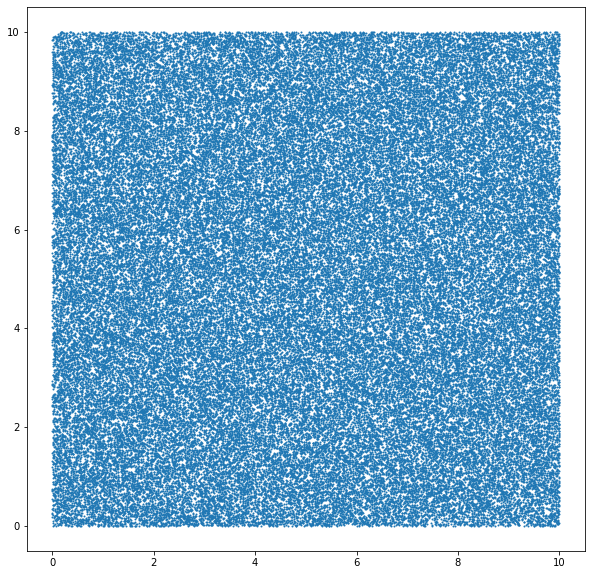

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(xb[:, 0], xb[:, 1], s=1)

In [26]:
%%time
res = faiss.StandardGpuResources()
D, I = faiss.knn_gpu(res, xb, xb, 100)

CPU times: user 201 ms, sys: 254 ms, total: 455 ms
Wall time: 459 ms


In [27]:
%%time
D, I = D.to(device), I.to(device)
ind = torch.Tensor.repeat(
        torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1
).T
edge_list = torch.stack([ind[D <= r_max ** 2], I[D <= r_max ** 2]])

# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

CPU times: user 28.5 ms, sys: 1.54 ms, total: 30.1 ms
Wall time: 29.1 ms


In [19]:
edge_list.shape

torch.Size([2, 99894664])

# Bentley From Scratch

1. Make grid
2. Hash the grid dictionary (?) Or is it faster to vectorize by keeping as a k-Array
3. Throw away empty grids
4. Build point neighbourhood array
5. Over neighbourhood array generate pairs 

In [3]:
from itertools import permutations, product

## Make Grid

In [44]:
d = 2                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device)

1. Grid size

In [45]:
%%time
x_cell_ref = (xb // r_max).int()

CPU times: user 94 µs, sys: 70 µs, total: 164 µs
Wall time: 169 µs


In [46]:
%%time
all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

CPU times: user 287 µs, sys: 216 µs, total: 503 µs
Wall time: 330 µs


In [66]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0, 1])]*d)), start_dim=1).T
exclusive_nhood = torch.cat([inclusive_nhood[:len(inclusive_nhood)//2], inclusive_nhood[len(inclusive_nhood)//2+1:]]).to(device)

Previous implementation

In [13]:
%%time
for cell in all_cells:
    x_in_cell = torch.where((x_cell_ref == cell).all(1))[0]
    length_list = torch.arange(len(x_in_cell)).to(device)
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, length_list)), start_dim=1).T

CPU times: user 24.6 ms, sys: 431 µs, total: 25.1 ms
Wall time: 24.3 ms


In [81]:
%%time
for cell in all_cells:
    x_in_nhood = torch.where((x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0))[0]
    nhood_length_list = torch.arange(len(x_in_nhood)).to(device)
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, nhood_length_list)), start_dim=1).T

CPU times: user 80.4 ms, sys: 8.31 ms, total: 88.7 ms
Wall time: 87.9 ms


Faster implementation

In [48]:
%%time
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_cell)), start_dim=1)

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 14.6 ms


In [49]:
%%time
for cell in all_cells:
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1).T

CPU times: user 30.6 ms, sys: 2.83 ms, total: 33.4 ms
Wall time: 32.8 ms


In [98]:
%%time
in_cell_combinations = in_cell_combinations[:, in_cell_combinations[0] != in_cell_combinations[1]]

CPU times: user 302 µs, sys: 270 µs, total: 572 µs
Wall time: 365 µs


In [102]:
all_radius_edges = []

In [103]:
%%time
all_radius_edges.append(in_cell_combinations[:, torch.sum( (xb[in_cell_combinations[0]] - xb[in_cell_combinations[1]])**2, dim=1) < r_max**2])

CPU times: user 395 µs, sys: 364 µs, total: 759 µs
Wall time: 541 µs


Adding in distance calculation

In [68]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_cell)), start_dim=1)
    all_radius_edges.append(in_cell_combinations[:, torch.sum( (xb[in_cell_combinations[0]] - xb[in_cell_combinations[1]])**2, dim=1) < r_max**2])

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 40.8 ms


In [54]:
%%time
for cell in all_cells:
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1).T
    all_radius_edges.append(out_cell_combinations[:, torch.sum( (xb[out_cell_combinations[0]] - xb[out_cell_combinations[1]])**2, dim=1) < r_max**2])

CPU times: user 51.7 ms, sys: 7.75 ms, total: 59.5 ms
Wall time: 58.9 ms


## Improvements

### Triangulate

In [55]:
d = 2                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device)

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

Only consider lower cells, (and upper triangle of of each meshgrid - THIS IS NOT WORKING EFFECTIVELY YET!)

In [69]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T
exclusive_nhood = inclusive_nhood[:-1].to(device)

In [72]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_cell)), start_dim=1)
    all_radius_edges.append(in_cell_combinations[:, torch.sum( (xb[in_cell_combinations[0]] - xb[in_cell_combinations[1]])**2, dim=1) < r_max**2].int())

CPU times: user 45 ms, sys: 647 µs, total: 45.6 ms
Wall time: 44.9 ms


In [65]:
%%time
for cell in all_cells:
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1).T
        all_radius_edges.append(out_cell_combinations[:, torch.sum( (xb[out_cell_combinations[0]] - xb[out_cell_combinations[1]])**2, dim=1) < r_max**2].int())

CPU times: user 49 ms, sys: 633 µs, total: 49.6 ms
Wall time: 49 ms


In [43]:
torch.cuda.max_memory_allocated() / 1024**3

6.425723552703857

In [12]:
%%time
upper_tri = torch.transpose(torch.stack(torch.meshgrid(length_list, length_list)), 0, 2)[torch.triu_indices(len(length_list), len(length_list)).T]

CPU times: user 9.02 s, sys: 13.3 s, total: 22.3 s
Wall time: 26.6 s


In [60]:
torch.flatten(torch.triu(torch.stack(torch.meshgrid(length_list, length_list))), start_dim=1).shape

torch.Size([2, 674041])

In [29]:
%%time
torch.flatten(torch.stack(torch.meshgrid(length_list, length_list)), start_dim=1).T.shape

CPU times: user 252 µs, sys: 258 µs, total: 510 µs
Wall time: 296 µs


torch.Size([664225, 2])

In [38]:
%%time
for cell in all_cells:
    x_in_nhood = torch.where((x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).any(0))[0]
    nhood_length_list = torch.arange(len(x_in_nhood)).to(device)
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, nhood_length_list)), start_dim=1).T

CPU times: user 560 ms, sys: 59.2 ms, total: 619 ms
Wall time: 313 ms


### Don't discriminate between inner and outer nhoods

In [3]:
d = 8                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

Only consider lower cells, (and upper triangle of of each meshgrid - THIS IS NOT WORKING EFFECTIVELY YET!)

In [4]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T.to(device)

In [5]:
inclusive_nhood.shape

torch.Size([256, 8])

In [6]:
all_cells.shape

torch.Size([100000000, 8])

### Comparing Steps

In [37]:
%%time
all_radius_edges = []
for cell in all_cells[:20]:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
#     x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
#     if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
#         all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2].int())
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 1.34 ms, sys: 1.37 ms, total: 2.71 ms
Wall time: 2.24 ms


In [6]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_radius_edges.append(torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1))
all_radius_edges = torch.cat(all_radius_edges, dim=1)
all_radius_edges = all_radius_edges[:, torch.max( (xb[all_radius_edges[0].long()] - xb[all_radius_edges[1].long()]), dim=1) < r_max**2]

# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

RuntimeError: CUDA out of memory. Tried to allocate 21.53 GiB (GPU 0; 15.78 GiB total capacity; 9.42 GiB already allocated; 3.79 GiB free; 10.78 GiB reserved in total by PyTorch)

In [29]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges = xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()]
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 34.4 ms, sys: 0 ns, total: 34.4 ms
Wall time: 33.9 ms


In [28]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges = all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2]
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 50.5 ms, sys: 0 ns, total: 50.5 ms
Wall time: 49.8 ms


In [6]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2])
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 87.3 ms, sys: 31.6 ms, total: 119 ms
Wall time: 118 ms


### Comparing Dimensionality

In [6]:
%%time
all_radius_edges = []
for cell in all_cells[:40]:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2])

CPU times: user 584 ms, sys: 232 ms, total: 816 ms
Wall time: 815 ms


In [7]:
%%time
all_edges = torch.cat(all_radius_edges, dim=1)

v = torch.ones(all_edges.shape[1], device = device)
all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 1.01 ms, sys: 612 µs, total: 1.62 ms
Wall time: 134 ms


### Prebuilt Neighbourhoods

In [44]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0), 0, 1)
all_radius_edges = []
for cell in all_cells[:40]:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(nbhood_map == cell).all(2).any(1)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2])

CPU times: user 99.1 ms, sys: 23 ms, total: 122 ms
Wall time: 121 ms


In [69]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0), 0, 1)
all_radius_edges = []
for cell in all_cells[:40]:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = (nbhood_map == cell)
#     x_in_nhood = xb_ind[(nbhood_map == cell).all(2).any(1)]
#     if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
#         all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2])

CPU times: user 59 ms, sys: 38.9 ms, total: 98 ms
Wall time: 97.2 ms


### The Total Algorithm

In [20]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2].int())

all_radius_edges = torch.cat(all_radius_edges, dim=1)

v = torch.ones(all_radius_edges.shape[1], device = device)
all_radius_edges = torch.sparse_coo_tensor(all_radius_edges, v).coalesce().indices()

all_radius_edges = torch.cat([all_radius_edges, torch.flip(all_radius_edges, dims=[0])], dim=1)
all_radius_edges = all_radius_edges[:, all_radius_edges[0] > all_radius_edges[1]]

RuntimeError: CUDA out of memory. Tried to allocate 5.45 GiB (GPU 0; 15.78 GiB total capacity; 6.14 GiB already allocated; 959.75 MiB free; 13.63 GiB reserved in total by PyTorch)

In [36]:
torch.cuda.max_memory_allocated() / 1024**3

4.0454936027526855

In [12]:
%%time
upper_tri = torch.transpose(torch.stack(torch.meshgrid(length_list, length_list)), 0, 2)[torch.triu_indices(len(length_list), len(length_list)).T]

CPU times: user 9.02 s, sys: 13.3 s, total: 22.3 s
Wall time: 26.6 s


In [60]:
torch.flatten(torch.triu(torch.stack(torch.meshgrid(length_list, length_list))), start_dim=1).shape

torch.Size([2, 674041])

In [29]:
%%time
torch.flatten(torch.stack(torch.meshgrid(length_list, length_list)), start_dim=1).T.shape

CPU times: user 252 µs, sys: 258 µs, total: 510 µs
Wall time: 296 µs


torch.Size([664225, 2])

In [38]:
%%time
for cell in all_cells:
    x_in_nhood = torch.where((x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).any(0))[0]
    nhood_length_list = torch.arange(len(x_in_nhood)).to(device)
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, nhood_length_list)), start_dim=1).T

CPU times: user 560 ms, sys: 59.2 ms, total: 619 ms
Wall time: 313 ms


# Compare to FNNS

In [3]:
import frnn

In [14]:
d = 2                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
# all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

In [15]:
%%time
# first time there is no cached grid
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=xb.unsqueeze(0), points2=xb.unsqueeze(0), lengths1=None, lengths2=None, K=32, r=1.0, grid=None, return_nn=False, return_sorted=True
)

CPU times: user 2.86 ms, sys: 0 ns, total: 2.86 ms
Wall time: 2.42 ms


In [17]:
%%time
dists, idxs, nn, grid = frnn.frnn_grid_points(
    points1=xb.unsqueeze(0), points2=xb.unsqueeze(0), lengths1=None, lengths2=None, K=32, r=1.0, grid=grid, return_nn=False, return_sorted=True
)

CPU times: user 623 µs, sys: 510 µs, total: 1.13 ms
Wall time: 779 µs


# Hashing Development

In [3]:
d = 8                        # dimension
r_max = 5
r_query = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
# all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(int(L_box // r_max + 1)).to(device)]*d)), start_dim=1).T

inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

In [4]:
reshape_dims = [int(L_box // r_max + 1)]*d
cell_index_length = np.product(reshape_dims)
cell_lookup = torch.arange(cell_index_length, device=device, dtype=torch.int).reshape(reshape_dims)

In [5]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0), 0, 1)
hit_nhood_lookup = cell_lookup[nbhood_map.long().chunk(chunks=d, dim=2)].squeeze()
hit_lookup = cell_lookup[x_cell_ref.long().chunk(chunks=d, dim=1)].squeeze()

CPU times: user 0 ns, sys: 3.87 ms, total: 3.87 ms
Wall time: 4.11 ms


In [6]:
%%time
_, flat_inverses, flat_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True)

CPU times: user 11.2 ms, sys: 7.53 ms, total: 18.8 ms
Wall time: 18.1 ms


In [7]:
%%time
D_cells = torch.unique(hit_lookup[(flat_counts[flat_inverses] > 1).any(1)])

CPU times: user 2.36 ms, sys: 0 ns, total: 2.36 ms
Wall time: 1.9 ms


In [8]:
D_cells_grid = all_cells[D_cells.long()]

NameError: name 'all_cells' is not defined

In [ ]:
%%time
cell_nbhood_map = torch.transpose(D_cells_grid.expand(len(inclusive_nhood), len(D_cells_grid), d) + torch.transpose(inclusive_nhood.expand(len(D_cells_grid), len(inclusive_nhood), d), 1, 0), 0, 1)
cell_nbhood_lookup = cell_lookup[cell_nbhood_map.long().chunk(chunks=d, dim=2)].squeeze()

Radius cut on-the-fly

In [8]:
%%time
all_radius_edges = []
for cell in D_cells:
    x_in_cell = xb_ind[(hit_lookup == cell)]
    x_in_nhood = xb_ind[(hit_nhood_lookup == cell).any(1)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])

CPU times: user 479 ms, sys: 156 ms, total: 635 ms
Wall time: 634 ms


In [ ]:
%%time
all_radius_edges = []
for cell in D_cells:
    x_in_cell = xb_ind[(hit_lookup == cell)]
    x_in_nhood = xb_ind[(hit_nhood_lookup == cell).any(1)]

Radius cut after-the-fact

In [ ]:
%%time
all_radius_edges = []
for cell in D_cells:
    x_in_cell = xb_ind[(hit_lookup == cell)]
    x_in_nhood = xb_ind[(hit_nhood_lookup == cell).any(1)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations)
all_radius_edges = torch.cat(all_radius_edges, dim=1)
all_radius_edges = all_radius_edges[:, torch.sum( (xb[all_radius_edges[0].long()] - xb[all_radius_edges[1].long()])**2, dim=1) < r_query**2]

In [ ]:
%%time
NE_cells, _, _ = torch.unique(hit_lookup, return_inverse=True, return_counts=True, dim=0)

In [ ]:
%%time
combined_uniques, combined_counts = torch.unique(torch.cat([NE_cells, torch.unique(D_cells)]), return_counts=True)

In [ ]:
%%time
nb_uniques, nb_inverses, nb_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True, dim=0)

## Prebuild Neighbourhoods

In [17]:
D_cells.shape

torch.Size([256])

In [9]:
%%time
x_in_cell = []
x_in_nhood = []
hit_batch = []
hit_nb_batch = []
for cell in D_cells.split(100):

    hit_mask = (hit_lookup[:, None] == cell).T
    nb_mask = (hit_nhood_lookup[:, :, None] == cell).any(1).T

    x_in_cell.append(xb_ind.expand(cell.shape[0], -1)[hit_mask])
    x_in_nhood.append(xb_ind.expand(cell.shape[0], -1)[nb_mask])
    
    hit_batch.append(cell.expand(hit_mask.shape[1], -1).T[hit_mask])
    hit_nb_batch.append(cell.expand(hit_mask.shape[1], -1).T[nb_mask])
    
x_in_cell = torch.cat(x_in_cell)
x_in_nhood = torch.cat(x_in_nhood)
hit_batch = torch.cat(hit_batch)
hit_nb_batch = torch.cat(hit_nb_batch)

CPU times: user 234 ms, sys: 66.8 ms, total: 300 ms
Wall time: 306 ms


In [8]:
%%time
## SINGLE INDEX VERSION
x_in_cell = []
x_in_nhood = []
hit_batch = []
hit_nb_batch = []
for cell in D_cells.split(100):

    hit_mask = (hit_lookup[:, None] == cell).T
    nb_mask = (hit_nhood_lookup[:, :, None] == cell).any(1).T

    x_in_cell.append(xb.expand(cell.shape[0], -1, -1)[hit_mask])
    x_in_nhood.append(xb.expand(cell.shape[0], -1, -1)[nb_mask])
    
    hit_batch.append(cell.expand(hit_mask.shape[1], -1).T[hit_mask])
    hit_nb_batch.append(cell.expand(hit_mask.shape[1], -1).T[nb_mask])
    
x_in_cell = torch.cat(x_in_cell)
x_in_nhood = torch.cat(x_in_nhood)
hit_batch = torch.cat(hit_batch)
hit_nb_batch = torch.cat(hit_nb_batch)

CPU times: user 40.6 ms, sys: 24.4 ms, total: 65 ms
Wall time: 64.4 ms


In [11]:
%%time
hit_mask = (hit_lookup[:, None] == D_cells).T
nb_mask = (hit_nhood_lookup[:, :, None] == D_cells).any(1).T

x_in_cell = xb_ind.expand(D_cells.shape[0], -1)[hit_mask]
x_in_nhood = xb_ind.expand(D_cells.shape[0], -1)[nb_mask]

CPU times: user 29.5 ms, sys: 25.1 ms, total: 54.6 ms
Wall time: 53.9 ms


To get maxes for meshgrid we need cellrefs masked, and get the torchunique count maxes for each

In [12]:
%%time
hit_batch = D_cells.expand(hit_mask.shape[1], -1).T[hit_mask]
hit_nb_batch = D_cells.expand(hit_mask.shape[1], -1).T[nb_mask]

CPU times: user 16.1 ms, sys: 28 µs, total: 16.1 ms
Wall time: 15.4 ms


In [15]:
hit_nb_batch.shape

torch.Size([2871771])

In [9]:
%%time
hit_cell_counts = torch.unique(hit_batch, return_counts=True)[1]
hit_cell_cumsum = hit_cell_counts.cumsum(0).roll(1)
hit_cell_cumsum[0] = 0
hit_max = hit_cell_counts.max()
nb_cell_counts = torch.unique(hit_nb_batch, return_counts=True)[1]
nb_cell_cumsum = nb_cell_counts.cumsum(0).roll(1)
nb_cell_cumsum[0] = 0
nb_max = nb_cell_counts.max()

CPU times: user 2.1 ms, sys: 0 ns, total: 2.1 ms
Wall time: 1.72 ms


In [10]:
%%time
ref_mesh = torch.stack(torch.meshgrid(torch.arange(hit_max, device=device), torch.arange(nb_max, device=device)))

CPU times: user 327 µs, sys: 223 µs, total: 550 µs
Wall time: 368 µs


In [11]:
D_cells.shape, hit_cell_counts.shape

(torch.Size([256]), torch.Size([256]))

In [12]:
hit_batch.shape, hit_nb_batch.shape

(torch.Size([100000]), torch.Size([2584713]))

In [13]:
x_in_cell.shape

torch.Size([100000, 8])

In [15]:
del hit_batch
del hit_nb_batch
del nbhood_map
del hit_nhood_lookup
del hit_lookup

In [16]:
D_cells[-1]

tensor(3280, device='cuda:0', dtype=torch.int32)

In [19]:
%%time
all_hits = []
all_nbs = []
for cell, hit_count, nb_count, hit_cumsum, nb_cumsum in zip(D_cells, hit_cell_counts, nb_cell_counts, hit_cell_cumsum, nb_cell_cumsum):
    local_edges = torch.flatten(ref_mesh[:, :hit_count, :nb_count], start_dim=1)
    local_edges[0] = local_edges[0] + hit_cumsum
    local_edges[1] = local_edges[1] + nb_cumsum
    hit_indices = x_in_cell.half()[local_edges[0]]
    nb_indices = x_in_nhood.half()[local_edges[1]]

    all_hits.append(hit_indices)
    all_nbs.append(nb_indices)
    
    print(cell)
#     print(local_edges.shape, hit_cumsum, nb_cumsum)

tensor(0, device='cuda:0', dtype=torch.int32)
tensor(1, device='cuda:0', dtype=torch.int32)
tensor(3, device='cuda:0', dtype=torch.int32)
tensor(4, device='cuda:0', dtype=torch.int32)


RuntimeError: CUDA out of memory. Tried to allocate 844.00 MiB (GPU 0; 15.78 GiB total capacity; 12.51 GiB already allocated; 611.75 MiB free; 13.97 GiB reserved in total by PyTorch)

In [18]:
%%time
all_hits = []
all_nbs = []
for cell, hit_count, nb_count, hit_cumsum, nb_cumsum in zip(D_cells, hit_cell_counts, nb_cell_counts, hit_cell_cumsum, nb_cell_cumsum):
    local_edges = torch.flatten(ref_mesh[:, :hit_count, :nb_count], start_dim=1)
    local_edges[0] = local_edges[0] + hit_cumsum
    local_edges[1] = local_edges[1] + nb_cumsum
    hit_indices = x_in_cell.half()[local_edges[0]]
    nb_indices = x_in_nhood.half()[local_edges[1]]

    edge_mask = torch.sum( (hit_indices - nb_indices)**2, dim=1) < r_query**2
    
    all_hits.append(local_edges[0][edge_mask])
    all_nbs.append(local_edges[1][edge_mask])
    
#     print(cell)
    
#     print(local_edges.shape, hit_cumsum, nb_cumsum)

CPU times: user 404 ms, sys: 152 ms, total: 556 ms
Wall time: 555 ms


In [27]:
all_hits

[tensor([   0,    1,    2,  ..., 1576, 1576, 1577], device='cuda:0')]

In [28]:
hit_indices

tensor([[2.0781, 4.5508, 3.9492, 3.6250, 0.4001, 4.8711],
        [2.0781, 4.5508, 3.9492, 3.6250, 0.4001, 4.8711],
        [2.0781, 4.5508, 3.9492, 3.6250, 0.4001, 4.8711],
        ...,
        [1.7305, 0.2174, 2.0449, 0.1467, 2.6406, 3.7090],
        [1.7305, 0.2174, 2.0449, 0.1467, 2.6406, 3.7090],
        [1.7305, 0.2174, 2.0449, 0.1467, 2.6406, 3.7090]], device='cuda:0',
       dtype=torch.float16)

In [19]:
ref_mesh.shape

torch.Size([2, 214, 11637])

In [20]:
%%time
del hit_batch
del hit_nb_batch

del ref_mesh

del hit_mask
del nb_mask
del x_in_cell
del x_in_nhood

del nbhood_map
del hit_nhood_lookup
del hit_lookup
del local_edges

CPU times: user 27 µs, sys: 23 µs, total: 50 µs
Wall time: 51.7 µs


In [21]:
len(all_hits), len(all_nbs)

(729, 729)

In [22]:
%%time
all_hits = torch.cat(all_hits[:73]).long()

CPU times: user 1.9 ms, sys: 2.12 ms, total: 4.02 ms
Wall time: 3.49 ms


In [23]:
%%time
all_nbs = torch.cat(all_nbs[:73]).long()

CPU times: user 1.63 ms, sys: 1.49 ms, total: 3.13 ms
Wall time: 2.7 ms


In [27]:
%%time
for i in range(10):
    edge_mask = torch.sum( (xb[all_hits] - xb[all_nbs])**2, dim=1) < r_query**2

CPU times: user 936 µs, sys: 4.91 ms, total: 5.84 ms
Wall time: 5.27 ms


In [24]:
%%time
all_hits = all_hits[edge_mask]
all_nbs = all_nbs[edge_mask]

CPU times: user 5.17 ms, sys: 0 ns, total: 5.17 ms
Wall time: 4.41 ms


In [34]:
local_edges.dtype

torch.int64

In [26]:
del all_hits
del all_nbs

In [19]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    1070 MB |    4488 MB |  221031 MB |  219960 MB |
|       from large pool |    1068 MB |    4486 MB |  220898 MB |  219830 MB |
|       from small pool |       2 MB |       4 MB |     133 MB |     130 MB |
|---------------------------------------------------------------------------|
| Active memory         |    1070 MB |    4488 MB |  221031 MB |  219960 MB |
|       from large pool |    1068 MB |    4486 MB |  220898 MB |

In [22]:
torch.cuda.max_memory_allocated()/1024**3

10.144341945648193

## Attempt at Full Neighbourhood Builder

In [32]:
%%time
for _ in range(100000):
    ref_mesh = torch.stack(torch.meshgrid(x_in_cell, x_in_nhood))

CPU times: user 3.48 s, sys: 0 ns, total: 3.48 s
Wall time: 3.48 s


In [14]:
ref_mesh[:, :100, :100].shape

torch.Size([2, 100, 100])

In [25]:
ref_mesh.shape

torch.Size([2, 980, 980])

In [29]:
%%time
for i in range(100000):
    j = int(i/1000)
    test = ref_mesh[:, :j, :j]

CPU times: user 429 ms, sys: 0 ns, total: 429 ms
Wall time: 428 ms


In [233]:
valid_hits = hit_lookup[(flat_counts[flat_inverses] > 1).any(1)]

In [234]:
%%time
sorted_unique_hits, sorted_counts = torch.unique(valid_hits, return_counts = True)

CPU times: user 414 µs, sys: 518 µs, total: 932 µs
Wall time: 643 µs


In [235]:
%%time
sorted_hits, sorted_idx = valid_hits.sort()

CPU times: user 266 µs, sys: 333 µs, total: 599 µs
Wall time: 388 µs


In [236]:
%%time
hits_cumsum = torch.cumsum(sorted_counts, dim=0)

CPU times: user 55 µs, sys: 70 µs, total: 125 µs
Wall time: 129 µs


In [237]:
sorted_unique_hits

tensor([     1032,      3729,      5759,  ..., 192915241, 192918464,
        192919412], device='cuda:0', dtype=torch.int32)

In [238]:
sorted_hits

tensor([     1032,      3729,      5759,  ..., 192915241, 192918464,
        192919412], device='cuda:0', dtype=torch.int32)

In [239]:
hits_cumsum

tensor([    1,     2,     3,  ..., 94240, 94241, 94242], device='cuda:0')

In [240]:
hits_cumsum.shape

torch.Size([94194])

In [263]:
%%time
split_list = tuple(sorted_counts)

CPU times: user 125 ms, sys: 17.7 ms, total: 143 ms
Wall time: 142 ms


In [267]:
%%time
split_hits = sorted_hits.split(tuple(sorted_counts))

CPU times: user 1.25 s, sys: 176 ms, total: 1.43 s
Wall time: 1.43 s


In [241]:
%%time
for i in range(99):
    x_in_cell = sorted_hits[hits_cumsum[i]:hits_cumsum[i+1]]

CPU times: user 3.7 ms, sys: 0 ns, total: 3.7 ms
Wall time: 3.27 ms


In [242]:
%%time
for i in range(99):
    x_in_cell = xb_ind[(hit_lookup == cell)]

CPU times: user 7.86 ms, sys: 0 ns, total: 7.86 ms
Wall time: 7.21 ms


In [250]:
nb_cells = torch.arange(1, 257, device=device)

Given cell = 2, nb_cells = [1, 2]. 

In [223]:
nb_cells = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [211]:
cell = torch.tensor([2], device=device)

In [274]:
split_hits[nb_cells]

TypeError: only integer tensors of a single element can be converted to an index

In [252]:
%%time
for i in range(99):
    all_nbs = torch.cat([sorted_hits[hits_cumsum[nb-1] : hits_cumsum[nb]] for nb in nb_cells])

CPU times: user 1.65 s, sys: 153 ms, total: 1.8 s
Wall time: 1.8 s


In [253]:
%%time
for i in range(99):
    x_in_nhood = xb_ind[(hit_nhood_lookup == cell).any(1)]

CPU times: user 23.9 ms, sys: 7.88 ms, total: 31.7 ms
Wall time: 31.1 ms


In [164]:
hits_cumsum[nb_cells]

tensor([1956, 2943], device='cuda:0')

In [165]:
hits_cumsum[nb_cells-1]

tensor([ 950, 1956], device='cuda:0')

In [162]:
sorted_hits[0:10]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0', dtype=torch.int32)

In [170]:
slice(hits_cumsum[nb_cells[0]], hits_cumsum[nb_cells[1]])

slice(tensor(1956, device='cuda:0'), tensor(2943, device='cuda:0'), None)

In [178]:
%%time
sorted_hits[(slice(hits_cumsum[nb_cells[0]-1], hits_cumsum[nb_cells[0]]), slice(hits_cumsum[nb_cells[1]-1], hits_cumsum[nb_cells[1]]),)]

IndexError: too many indices for tensor of dimension 1

In [193]:
%%time
for i in range(99):
    all_nbs = sorted_hits[torch.cat([torch.arange(hits_cumsum[nb-1], hits_cumsum[nb], device=device) for nb in nb_cells])]

CPU times: user 35.6 ms, sys: 0 ns, total: 35.6 ms
Wall time: 34.9 ms


### ... Put a pin in this...

## Batching

Two options. Option 1: `any` of hits in batch can go into radius test:

### Option 1

In [10]:
D_cells.shape

torch.Size([256])

In [84]:
%%time
all_radius_edges = []
for cell in D_cells.split(1):
    
    x_in_cell = xb_ind[(hit_lookup[:, None] == cell).any(1)]
    x_in_nhood = xb_ind[(hit_nhood_lookup[:, :, None] == cell).any(1).any(1)]
    
    all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
    all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])    
    
    break

CPU times: user 16.9 ms, sys: 5.4 ms, total: 22.3 ms
Wall time: 21.5 ms


In [16]:
%%time
all_radius_edges = []
for cell in D_cells.split(1):
    
    x_in_cell = xb_ind[(hit_lookup[:, None] == cell).any(1)]
    x_in_nhood = xb_ind[(hit_nhood_lookup[:, :, None] == cell).any(1).any(1)]
    
    all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
    all_radius_edges.append(all_cell_combinations)
    
# all_radius_edges = torch.cat(all_radius_edges, dim=1)
# all_radius_edges = all_radius_edges[:, torch.sum( (xb[all_radius_edges[0].long()] - xb[all_radius_edges[1].long()])**2, dim=1) < r_query**2]

CPU times: user 106 ms, sys: 18.7 ms, total: 125 ms
Wall time: 124 ms


In [23]:
%%time
for i, edges in enumerate(all_radius_edges):
    all_radius_edges[i] = edges[:, torch.sum( (xb[edges[0].long()] - xb[edges[1].long()])**2, dim=1) < r_query**2]

CPU times: user 353 ms, sys: 153 ms, total: 506 ms
Wall time: 505 ms


In [59]:
torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1)

tensor([ 0.0000, 27.9710, 24.6993,  ..., 31.0282, 38.6803,  0.0000],
       device='cuda:0')

In [15]:
torch.sum( (xb[all_radius_edges[0][0].long()] - xb[all_radius_edges[0][1].long()])**2, dim=1) < r_query**2

tensor([False, False, False,  ..., False, False, False], device='cuda:0')

In [25]:
all_radius_edges[0].shape

torch.Size([2, 346])

In [36]:
all_radius_edges[0].shape

torch.Size([2, 39900000])

### Option 2

Here we would like to only mesh together those edges that are in the same batch

In [10]:
valid_hits = hit_lookup[(flat_counts[flat_inverses] > 1).any(1)]

In [11]:
%%time
sorted_unique_hits, sorted_counts = torch.unique(valid_hits, return_counts = True)

CPU times: user 1.44 ms, sys: 0 ns, total: 1.44 ms
Wall time: 1.1 ms


In [12]:
%%time
sorted_hits, sorted_idx = valid_hits.sort()

CPU times: user 534 µs, sys: 379 µs, total: 913 µs
Wall time: 670 µs


In [13]:
sorted_counts

tensor([410, 373, 413, 394, 378, 377, 402, 372, 382, 377, 415, 380, 397, 371,
        384, 396, 391, 400, 365, 400, 402, 402, 373, 352, 398, 371, 388, 333,
        381, 416, 386, 390, 410, 395, 411, 382, 381, 371, 412, 408, 354, 395,
        373, 382, 407, 357, 380, 403, 348, 386, 389, 431, 360, 399, 402, 379,
        376, 400, 372, 380, 382, 374, 399, 419, 380, 406, 398, 341, 392, 388,
        384, 392, 380, 421, 429, 425, 406, 365, 392, 397, 365, 384, 371, 339,
        433, 376, 402, 359, 356, 397, 364, 369, 360, 397, 409, 375, 376, 385,
        353, 380, 441, 399, 406, 395, 399, 397, 391, 368, 398, 412, 392, 388,
        410, 386, 363, 360, 346, 393, 376, 389, 356, 412, 386, 407, 378, 391,
        369, 373, 408, 393, 398, 392, 393, 380, 403, 378, 390, 375, 428, 371,
        380, 404, 419, 407, 401, 398, 395, 410, 396, 413, 380, 401, 419, 416,
        395, 404, 418, 364, 387, 380, 421, 390, 411, 401, 377, 394, 380, 391,
        407, 392, 401, 386, 393, 350, 420, 412, 381, 386, 393, 4

In [19]:
ref_mesh = torch.stack(torch.meshgrid(torch.arange(max_hits, device=device), torch.arange(max_nbhood, device=device)))

In [20]:
ref_mesh.shape

torch.Size([2, 447, 100000])

In [33]:
%%time
all_radius_edges = []
batch_size = 1
max_hits, max_nbhood = 0, 0
for cell in cell_nbhood_lookup.split(batch_size):
    hit_mask = (hit_lookup[:, None] == cell[:, -1]).T
    hit_nb_mask = (hit_lookup[:,  None] == cell[ :, None]).any(2)
        
#     if hit_mask.sum() > max_hits:
#         max_hits = hit_mask.sum()
        
#     if hit_nb_mask.sum() > max_nbhood:
#         max_nbhood = hit_nb_mask.sum()
    
    x_in_cell = xb_ind.expand(cell.shape[0], -1)[hit_mask]
    x_in_nhood = xb_ind.expand(cell.shape[0], -1)[hit_nb_mask]
    
    hit_batch = cell[:, -1].expand(hit_mask.shape[1], -1).T[hit_mask]
    hit_nb_batch = cell[:, -1].expand(hit_mask.shape[1], -1).T[hit_nb_mask]
    
    
    all_radius_edges.append(torch.flatten(ref_mesh[:, :hit_mask.sum(), :hit_nb_mask.sum()], start_dim=1))
    
#     mesh_batch = torch.meshgrid(hit_batch, hit_nb_batch)
#     all_cell_combinations = torch.stack(torch.meshgrid(x_in_cell, x_in_nhood))[:, mesh_batch[0] == mesh_batch[1]]
#     all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])


RuntimeError: CUDA out of memory. Tried to allocate 282.00 MiB (GPU 0; 15.78 GiB total capacity; 14.32 GiB already allocated; 129.75 MiB free; 14.44 GiB reserved in total by PyTorch)

In [28]:
torch.cuda.max_memory_allocated()/1024**3

8.073482036590576

In [18]:
max_hits, max_nbhood

(tensor(447, device='cuda:0'), tensor(100000, device='cuda:0'))

In [53]:
cell_nbhood_lookup.shape

torch.Size([100, 4])

In [58]:
%%time
all_radius_edges = []
batch_size = 2
for cell in cell_nbhood_lookup.split(batch_size):
    
    hit_mask = (hit_lookup[:, None] == cell[:, -1]).T
    hit_nb_mask = (hit_lookup[:,  None] == cell[ :, None]).any(2)
    
    x_in_cell = xb_ind.expand(cell.shape[0], -1)[hit_mask]
    x_in_nhood = xb_ind.expand(cell.shape[0], -1)[hit_nb_mask]
    
    hit_batch = cell[:, -1].expand(hit_mask.shape[1], -1).T[hit_mask]
    hit_nb_batch = cell[:, -1].expand(hit_mask.shape[1], -1).T[hit_nb_mask]
    
    mesh_batch = torch.meshgrid(hit_batch, hit_nb_batch)
    all_cell_combinations = torch.stack(torch.meshgrid(x_in_cell, x_in_nhood))[:, mesh_batch[0] == mesh_batch[1]]
    all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])
    
#     all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
#     all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_query**2])

CPU times: user 115 ms, sys: 47.4 ms, total: 163 ms
Wall time: 162 ms


# PCA Approach

## Projection Prototype

In [23]:
d = 8                        # dimension
r_max = 5
r_query = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

In [24]:
projection_d = [0, 1, 2, 3, 4, 5, 6, 7]
dims = len(projection_d)

# Assign grid cells
x_cell_ref = (xb[:, projection_d] // r_max).int()

In [25]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*dims)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

In [26]:
reshape_dims = [int(L_box // r_max + 1)]*dims
cell_index_length = np.product(reshape_dims)
cell_lookup = torch.arange(cell_index_length, device=device, dtype=torch.int).reshape(reshape_dims)

In [27]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, dims) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), dims), 1, 0), 0, 1)
hit_nhood_lookup = cell_lookup[nbhood_map.long().chunk(chunks=dims, dim=2)].squeeze()
hit_lookup = cell_lookup[x_cell_ref.long().chunk(chunks=dims, dim=1)].squeeze()

_, flat_inverses, flat_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True)

D_cells = torch.unique(hit_lookup[(flat_counts[flat_inverses] > 1).any(1)])

CPU times: user 23.6 ms, sys: 3.36 ms, total: 26.9 ms
Wall time: 26.1 ms


In [28]:
%%time
# HIGH MEM VERSION
hit_mask = (hit_lookup[:, None] == D_cells).T
nb_mask = (hit_nhood_lookup[:, :, None] == D_cells).any(1).T

x_in_cell = xb.expand(D_cells.shape[0], -1, -1)[hit_mask]
x_in_nhood = xb.expand(D_cells.shape[0], -1, -1)[nb_mask]

hit_batch = D_cells.expand(hit_mask.shape[1], -1).T[hit_mask]
hit_nb_batch = D_cells.expand(hit_mask.shape[1], -1).T[nb_mask]

CPU times: user 44.8 ms, sys: 25 ms, total: 69.7 ms
Wall time: 68.9 ms


In [180]:
%%time
## LOW MEM VERSION
x_in_cell = []
x_in_nhood = []
hit_batch = []
hit_nb_batch = []
for cell in D_cells.split(100):

    hit_mask = (hit_lookup[:, None] == cell).T
    nb_mask = (hit_nhood_lookup[:, :, None] == cell).any(1).T

    x_in_cell.append(xb.expand(cell.shape[0], -1, -1)[hit_mask])
    x_in_nhood.append(xb.expand(cell.shape[0], -1, -1)[nb_mask])
    
    hit_batch.append(cell.expand(hit_mask.shape[1], -1).T[hit_mask])
    hit_nb_batch.append(cell.expand(hit_mask.shape[1], -1).T[nb_mask])
    
x_in_cell = torch.cat(x_in_cell)
x_in_nhood = torch.cat(x_in_nhood)
hit_batch = torch.cat(hit_batch)
hit_nb_batch = torch.cat(hit_nb_batch)

CPU times: user 289 ms, sys: 104 ms, total: 393 ms
Wall time: 392 ms


To get maxes for meshgrid we need cellrefs masked, and get the torchunique count maxes for each

In [29]:
%%time
hit_cell_counts = torch.unique(hit_batch, return_counts=True)[1]
hit_cell_cumsum = hit_cell_counts.cumsum(0).roll(1)
hit_cell_cumsum[0] = 0
hit_max = hit_cell_counts.max()
nb_cell_counts = torch.unique(hit_nb_batch, return_counts=True)[1]
nb_cell_cumsum = nb_cell_counts.cumsum(0).roll(1)
nb_cell_cumsum[0] = 0
nb_max = nb_cell_counts.max()

CPU times: user 2.25 ms, sys: 0 ns, total: 2.25 ms
Wall time: 1.78 ms


In [30]:
%%time
ref_mesh = torch.stack(torch.meshgrid(torch.arange(hit_max, device=device), torch.arange(nb_max, device=device)))

CPU times: user 296 µs, sys: 409 µs, total: 705 µs
Wall time: 469 µs


In [31]:
print(ref_mesh.shape, x_in_cell.shape, x_in_nhood.shape)

torch.Size([2, 448, 100000]) torch.Size([100000, 8]) torch.Size([2565031, 8])


In [32]:
%%time
all_hits = []
all_nbs = []
for cell, hit_count, nb_count, hit_cumsum, nb_cumsum in zip(D_cells, hit_cell_counts, nb_cell_counts, hit_cell_cumsum, nb_cell_cumsum):
    local_edges = torch.flatten(ref_mesh[:, :hit_count, :nb_count], start_dim=1)
    hit_indices = x_in_cell.half()[local_edges[0] + hit_cumsum]
    nb_indices = x_in_nhood.half()[local_edges[1] + nb_cumsum]
    
#     hit_indices = x_in_cell[local_edges[0] + hit_cumsum]
#     nb_indices = x_in_nhood[local_edges[1] + nb_cumsum]

    edge_mask = torch.sum( (hit_indices - nb_indices)**2, dim=1) < r_query**2
    
    all_hits.append(local_edges[0][edge_mask]+ hit_cumsum)
    all_nbs.append(local_edges[1][edge_mask]+ nb_cumsum)


CPU times: user 404 ms, sys: 127 ms, total: 531 ms
Wall time: 530 ms


In [116]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 4            |        cudaMalloc retries: 6         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  261943 KB |   13925 MB |    1372 GB |    1371 GB |
|       from large pool |  256964 KB |   13923 MB |    1342 GB |    1342 GB |
|       from small pool |    4978 KB |      51 MB |      29 GB |      29 GB |
|---------------------------------------------------------------------------|
| Active memory         |  261943 KB |   13925 MB |    1372 GB |    1371 GB |
|       from large pool |  256964 KB |   13923 MB |    1342 GB |

## Full PCA Prototype

1. Get 3D dataset
2. Get PCA in 2D
3. Build cells on 2D grid
4. Run on 2D grid, but get nbs based on 3D

In [23]:
d = 3                        # dimension
r_max = 1
r_query = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

In [42]:
#PCA construction
projection_d = 2
pca = decomposition.PCA(n_components = projection_d)

In [43]:
%%time
pca.fit(xb.cpu())

CPU times: user 105 ms, sys: 56.9 ms, total: 162 ms
Wall time: 82.7 ms


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [44]:
%%time
xb_pca = torch.from_numpy(pca.transform(xb.cpu())).float().to(device)
xb_pca.min()

# Assign grid cells
x_cell_ref = (xb_pca // r_max).int()

CPU times: user 5.11 ms, sys: 0 ns, total: 5.11 ms
Wall time: 3.8 ms


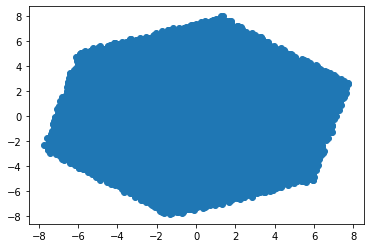

In [48]:
plt.scatter(xb_pca.cpu()[:,0], xb_pca.cpu()[:,1])

In [31]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*projection_d)), start_dim=1).T.to(device)
exclusive_nhood = inclusive_nhood[:-1]

In [32]:
reshape_dims = [int(L_box // r_max + 1)]*d
cell_index_length = np.product(reshape_dims)
cell_lookup = torch.arange(cell_index_length, device=device, dtype=torch.int).reshape(reshape_dims)

In [5]:
%%time
nbhood_map = torch.transpose(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0), 0, 1)
hit_nhood_lookup = cell_lookup[nbhood_map.long().chunk(chunks=d, dim=2)].squeeze()
hit_lookup = cell_lookup[x_cell_ref.long().chunk(chunks=d, dim=1)].squeeze()

CPU times: user 0 ns, sys: 3.87 ms, total: 3.87 ms
Wall time: 4.11 ms


In [6]:
%%time
_, flat_inverses, flat_counts = torch.unique(hit_nhood_lookup, return_inverse=True, return_counts=True)

CPU times: user 11.2 ms, sys: 7.53 ms, total: 18.8 ms
Wall time: 18.1 ms


In [7]:
%%time
D_cells = torch.unique(hit_lookup[(flat_counts[flat_inverses] > 1).any(1)])

CPU times: user 2.36 ms, sys: 0 ns, total: 2.36 ms
Wall time: 1.9 ms


In [11]:
%%time
hit_mask = (hit_lookup[:, None] == D_cells).T
nb_mask = (hit_nhood_lookup[:, :, None] == D_cells).any(1).T

x_in_cell = xb.expand(D_cells.shape[0], -1)[hit_mask]
x_in_nhood = xb.expand(D_cells.shape[0], -1)[nb_mask]

CPU times: user 29.5 ms, sys: 25.1 ms, total: 54.6 ms
Wall time: 53.9 ms


# Try With Real Data